In [60]:
import os
import glob
import numpy as np
import rasterio
from tqdm.auto import tqdm
from pathlib import Path
from PIL import ImageColor
from skimage import io

In [61]:
base_dir = '/home/nick/Documents/Work code/gimp_segmentation_plugin/sample data'

model_output_folder = 'model output'
image_dir = os.path.join(base_dir,model_output_folder)
print(os.path.isdir(image_dir))

mask_folder = 'mask'
mask_dir = os.path.join(base_dir,mask_folder)
Path(mask_dir).mkdir(parents=True, exist_ok=True)

full_colour_mask_folder = 'colour mask'
colour_mask_dir = os.path.join(base_dir,full_colour_mask_folder)
Path(colour_mask_dir).mkdir(parents=True, exist_ok=True)

files = glob.glob(image_dir+'/*')
len(files)

True


4

In [62]:
for file in tqdm(files):
#     make save path
    file_name = os.path.basename(file)
    save_path = os.path.join(mask_dir,file_name)
#     open mask with rasterio
    src = rasterio.open(file)
#     grab a copy of the metadata
    meta_copy = src.meta
#     grab array
    array = src.read()
#     get the layer index for the highest value for each pixel
    one_band = np.argmax(array,axis=0)
#     expand bands for rasterio
    one_band_exp = np.expand_dims(one_band,axis=0).astype('uint8')
#     edit metadata
    meta_copy['count'] = 1
    meta_copy['dtype'] = 'uint8'
#     save file out
    with rasterio.open(save_path, 'w', **meta_copy) as dst:
            dst.write(one_band_exp)
    
    

  0%|          | 0/4 [00:00<?, ?it/s]

In [63]:
# grab image shape
class_count = array.shape[0]
img_shape_x = array.shape[1]
img_shape_y = array.shape[2]
class_count

2

In [64]:
# 20 distinct colours, if you have more than 20 classes you will have an issue...
# from https://sashamaps.net/docs/resources/20-colors/
colours = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0',
           '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8',
           '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff',
           '#000000']

In [65]:
colours = colours[:class_count]
colours

['#e6194b', '#3cb44b']

In [66]:
# convert hex colours to RGB
rgb_list = []
for colour in colours:
        
    rgb_list.append(list(ImageColor.getcolor(colour, "RGB")))

# rgb_list = np.array(rgb_list[:class_count])
rgb_display = np.expand_dims(rgb_list,axis=0).astype('uint8')

In [98]:
pallette_header = ['GIMP Palette','Name: Image Segmentation Classes','Columns: 0','#']
for colour in rgb_display[0]:
        
    colour_string = ' '.join(map(str, colour)) 
    
    pallette_header.append(colour_string)

export_path = os.path.join(base_dir,'Image Segmentation Palette.txt')

np.savetxt(export_path, np.array(pallette_header,dtype=object), fmt='%s')
export_path

'/home/nick/Documents/Work code/gimp_segmentation_plugin/sample data/Image Segmentation Palette.txt'

[[230, 25, 75], [60, 180, 75]]


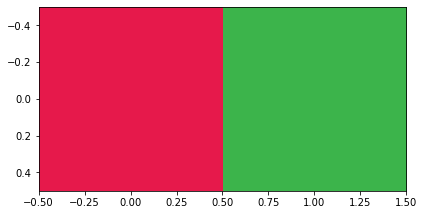

In [91]:
# these are the colours we will use
print(rgb_list)
io.imshow(rgb_display)

In [105]:
# grab list of masks
mask_list = glob.glob(mask_dir+'/*')
# loop over each mask
for file in mask_list:  
#     make save path for colour image
    file_name = os.path.basename(file)
    save_path = os.path.join(colour_mask_dir,file_name)
#     open mask with rasterio
    src = rasterio.open(file)
#     grab a copy of the metadata
    meta_copy = src.meta
#     grab array
    array = src.read()
#     make empty image of correct size and 3 bands
    three_band_image = np.zeros([3,img_shape_x,img_shape_y], dtype='uint8')
#     loop over each band
    for band in range(0,3):
#         loop over each class
        for int_class in range(0,class_count):
#         get the RGB value for this channel and class
            reclas_colour = rgb_list[int_class][band]
#         pretty much doing a reclass from the mask to GRB
            three_band_image[band][np.where(array[0] == int_class )] = reclas_colour
#     edit metadata
    meta_copy['count'] = 3
    meta_copy['dtype'] = 'uint8'
#     save file out
    with rasterio.open(save_path, 'w', **meta_copy) as dst:
            dst.write(three_band_image)